In [1]:
import numpy as np
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set data type
DTYPE=torch.float32

# Set constants
pi=torch.pi
viscosity = .01/pi
#viscosity=0.001

# Define initial condition
def fun_u_0(x):
    return -torch.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return torch.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

In [2]:
# Set number of data points
N_0 = 30
N_b = 30
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.



# Lower bounds
lb = torch.tensor([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = torch.tensor([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
#torch.manual_seed(0)

In [3]:
# sample initial value
t_0=torch.ones((N_0,1),dtype=DTYPE)*lb[0]
x_0=torch.rand((N_0,1),dtype=DTYPE)

# scale x_0 to between x_min and x_max
x_0=x_0*(ub[1]-lb[1]) + lb[1]

# concatenate t_0 and x_0 into an N_0 x 2 matrix
X_0 = torch.cat([t_0, x_0], axis=1)


# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

#u_0.shape is torch.Size([50, 1])

In [4]:
# Boundary data
t_b = torch.rand((N_b,1), dtype=DTYPE)
t_b = t_b*(ub[0] - lb[0])+lb[0]
x_b = lb[1] + (ub[1] - lb[1]) * torch.bernoulli(torch.ones((N_b,1))-1/2)
# or we can just create two N_b/2 by 1 tensors, one for each boundary


# concatenate to an N_b x 2 matrix
X_b = torch.cat([t_b, x_b], axis=1)


# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)



In [5]:
X_b.shape

torch.Size([30, 2])

In [6]:
# Initial and boundary data are only used to train
# the NN for initial and boundary condition

In [7]:
# Combining initial and boundary conditions
# X_ib is (N_0 + N_b) x 2
# u_ib is (N_0 + N_b) x 1

X_ib=torch.cat([X_0, X_b],axis=0)
u_ib=torch.cat([u_0, u_b],axis=0)

In [8]:
# Draw collocation points
t_r = torch.rand((N_r,1),dtype=DTYPE)
t_r = t_r*(ub[0]-lb[0])+lb[0]
x_r = torch.rand((N_r,1),dtype=DTYPE)
x_r = x_r*(ub[1]-lb[1])+lb[1]

X_r = torch.cat([t_r, x_r], axis=1)

# a small fraction of the collocation points are used to train the distance function
# the rest are for the PINN loss function

In [9]:
X_r.shape

torch.Size([10000, 2])

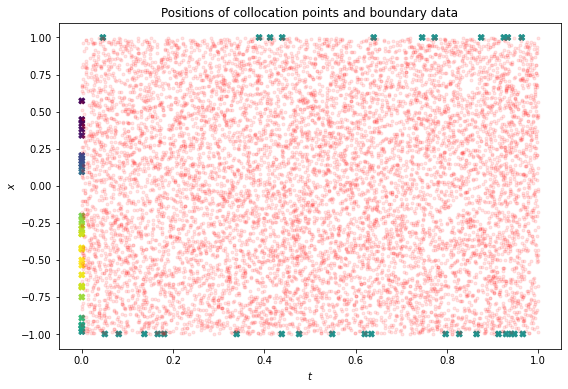

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [11]:
# Define the three NN

# D(x,t) distance function


def D_NN_constr(num_hidden_layers=2, num_neurons=5):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [12]:
# a NN to learn the initial and boundary conditions

def IB_constr(num_hidden_layers=2, num_neurons=5):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [13]:
# u_tilda(x,t) is the main NN

def u_tilda_constr(num_hidden_layers=8, num_neurons=20):
    layers = []
    layers.append(nn.Linear(2, num_neurons))
    layers.append(nn.Tanh())
    for _ in range(num_hidden_layers):
        layers.append(nn.Linear(num_neurons,num_neurons))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(num_neurons, 1))

    model = nn.Sequential(*layers)
    return model

In [14]:
# compute residual in the bulk to train u_tilda
# X_r is a (N_r x 2) torch tensor
# we need to input the other two networks


def get_r(u_net,D_net,IB_net, X_r):
    
    t, x = X_r[:, 0:1], X_r[:,1:2]
    # this way of slicing makes t and x both (N_r x 1) tensor
    # and NOT a [N_r] vector
    
    t.requires_grad_(requires_grad=True)
    x.requires_grad_(requires_grad=True)
    X = torch.stack([t[:,0], x[:,0]], axis=1)
    
    u = IB_net(X) + D_net(X) * u_net(X)
    #u = IB_net(X)*torch.exp(-15.*D_net(X)) + D_net(X) * u_net(X)
    
    # torch.stack([t[:,0], x[:,0]], axis=1) has shape (N_r x 2)
    # u has shape (N_r x 1)
    
    u_t=torch.autograd.grad(u,t,torch.ones_like(u),create_graph=True)[0]
    u_x=torch.autograd.grad(u,x,torch.ones_like(u),create_graph=True)[0]
    u_xx=torch.autograd.grad(u_x,x,torch.ones_like(u_x),create_graph=True)[0]
    # all derivatives have shape (N_r x 1) because of torch.ones_like(u)
    
    return fun_r(t, x, u, u_t, u_x, u_xx)

In [15]:
# Define a dataset with label
# used to train distance AND initial and boundary condition

class Dataset_label(Dataset):
    
    def __init__(self,data,label):
        self.data = data  
        self.label = label 
        self.N = len(data)  
        
    def __getitem__(self,index):
        return self.data[index],self.label[index]
    
    def __len__(self):
        return self.N

    
# Define a dataset WITHOUT label
# Used to train u_tilta

class Dataset_nolabel(Dataset):
    
    def __init__(self,data):
        self.data = data 
        self.N = len(data)  
        
    def __getitem__(self,index):
        return self.data[index]
    
    def __len__(self):
        return self.N


In [16]:
# Training distance D(x,t)

# preparing data
# use 50 points from initial, 50 from boundary, and 50 from collocation as training data

X_D_tr=torch.cat([X_0[0:20, :], X_b[0:20, :], X_r[0:50,:]],axis=0)

# creating label
# for each (t,x), D(x,t)=min(t-tmin, x-xmin, xmax-x)

d_tr=torch.zeros((90,1),dtype=DTYPE)

for i in range(90):
    t=X_D_tr[i,0]
    x=X_D_tr[i,1]
    d_tr[i,:]=min([t-tmin, x-xmin, xmax-x])
    
    
# Create validation data
# 10 points from initial, 10 points from boundary, 10 from collocation

X_D_val=torch.cat([X_0[20:30, :], X_b[20:30, :], X_r[20:30,:]],axis=0)

d_val=torch.zeros((30,1),dtype=DTYPE)

for i in range(30):
    t=X_D_val[i,0]
    x=X_D_val[i,1]
    d_val[i,:]=min([t-tmin, x-xmin, xmax-x])
    

    

In [17]:
# Create data loader for training D(x,t)

d_ds_tr=Dataset_label(X_D_tr, d_tr)
d_ds_val=Dataset_label(X_D_val, d_val)

d_loader_tr=DataLoader(d_ds_tr,batch_size = len(d_ds_tr),shuffle=False)
d_loader_val=DataLoader(d_ds_val,batch_size = len(d_ds_val),shuffle=False)

In [18]:
# create model for D

D_NN=D_NN_constr()

In [19]:
D_NN

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): Tanh()
  (6): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
type(D_NN)

torch.nn.modules.container.Sequential

In [18]:
# training function with label

def train_label(net, epochs, loader_tr, loader_val):
    loss_fcn=nn.MSELoss(reduction = 'mean')
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    for epoch in range(epochs):
        if epoch == 1000:
            optimizer = optim.Adam(net.parameters(), lr=1e-3)
        elif epoch == 3000:
            optim.Adam(net.parameters(), lr=5e-4)
        running_loss=0.
        optimizer.zero_grad()
        data_tr, label_tr = next(iter(loader_tr))
        label_predict=net(data_tr)
        loss=loss_fcn(label_predict, label_tr)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        print(running_loss)
        
        if epoch%50==49:
            val_loss=0.
            data_val, label_val=next(iter(loader_val))
            label_predict_val=net(data_val)
            val_loss+=loss_fcn(label_predict_val, label_val).item()
            print(f'validation loss: {val_loss}')
    print('Finished Training',running_loss)

        
        


In [19]:
train_label(D_NN, 5000, d_loader_tr, d_loader_val)

0.37619704008102417
0.315144419670105
0.2615514099597931
0.21522071957588196
0.1756254881620407
0.14221793413162231
0.11460928618907928
0.09252972155809402
0.07574563473463058
0.06398654729127884
0.05687446519732475
0.05385011434555054
0.05410214513540268
0.056548938155174255
0.059947188943624496
0.0631321594119072
0.06526219099760056
0.06592846661806107
0.06511633843183517
0.06308767944574356
0.060249920934438705
0.05704589933156967
0.05387532338500023
0.05104776844382286
0.04876235872507095
0.04710846021771431
0.04608101770281792
0.04560447111725807
0.04555950313806534
0.04580812528729439
0.04621420055627823
0.04665789008140564
0.0470442995429039
0.04730693995952606
0.047407642006874084
0.047333844006061554
0.04709450528025627
0.046715185046195984
0.0462329164147377
0.04569099843502045
0.04513398930430412
0.044603146612644196
0.04413241893053055
0.04374539107084274
0.04345334321260452
0.04325484484434128
0.04313686862587929
0.04307735338807106
0.04304906353354454
0.04302390292286873


0.00168130814563483
0.0016740267165005207
0.0016667349264025688
0.0016594326589256525
0.00165212107822299
0.0016447989037260413
0.001637467765249312
0.0016301263822242618
0.0016227778978645802
0.0016154199838638306
0.001608053338713944
0.0016006799414753914
0.001593299093656242
0.0015859102131798863
0.0015785160940140486
0.0015711153391748667
0.0015637079486623406
0.0015562961343675852
0.0015488800127059221
0.0015414593508467078
0.0015340368263423443
0.0015266082482412457
0.0015191787388175726
0.0015117484144866467
validation loss: 0.0009166087838821113
0.0015043162275105715
0.0014968827599659562
0.0014894497580826283
0.0014820168726146221
0.0014745864318683743
0.0014671572716906667
0.0014597296249121428
0.0014523057034239173
0.0014448856236413121
0.0014374710153788328
0.001430060830898583
0.001422656117938459
0.001415257342159748
0.0014078667154535651
0.0014004820259287953
0.0013931067660450935
0.0013857395388185978
0.0013783827889710665
0.001371034886687994
0.0013636983931064606
0.00

0.00015203809016384184
0.00015186317614279687
0.00015168888785410672
0.00015151515253819525
0.00015134175191633403
0.00015116883150767535
0.00015099607117008418
0.00015082406753208488
0.00015065270417835563
0.00015048163186293095
0.00015031109796836972
0.00015014068048913032
0.00014997136895544827
0.00014980191190261394
0.00014963300782255828
0.0001494649040978402
0.00014929668395780027
0.00014912990445736796
0.0001489627466071397
0.00014879641821607947
0.00014863008982501924
0.0001484645763412118
0.00014829912106506526
0.00014813528105150908
0.000147970873513259
validation loss: 0.00016602968389634043
0.00014780678611714393
0.00015357660595327616
0.00018318080401513726
0.00015624510706402361
0.0001568534498801455
0.00016281520947813988
0.00015851312491577119
0.0001512723247287795
0.00015102884208317846
0.00015610773698426783
0.00015584591892547905
0.00014963190187700093
0.0001470564166083932
0.00015119316230993718
0.00015359616372734308
0.00014999894483480603
0.00014654657570645213
0.

0.00011747599637601525
0.00011741936759790406
0.00011736250598914921
0.00011730597907444462
0.00011724936484824866
0.00011719304893631488
0.00011713672574842349
0.00011708036618074402
0.00011702391202561557
0.00011696776346070692
0.00011691186227835715
0.00011685593199217692
0.00011679980525514111
0.00011674348934320733
0.00011668770457617939
0.00011663188342936337
0.00011657606955850497
0.00011652007378870621
0.00011646439088508487
0.00011640889715636149
0.00011635302507784218
0.00011629758955677971
0.00011624196486081928
0.00011618663847912103
0.0001161311665782705
0.00011607563646975905
0.00011602052109083161
0.00011596509284572676
0.00011590988287935033
0.00011585486208787188
0.00011579987040022388
0.00011574456584639847
0.00011568927584448829
0.0001156347498181276
validation loss: 0.00014133108197711408
0.0001155797581304796
0.00011552466457942501
0.0001154701312771067
0.00011541564163053408
0.0001153606062871404
0.00011530592746566981
0.00011525126319611445
0.00011519643885549158

9.674068860476837e-05
9.589315595803782e-05
9.578576282365248e-05
9.630882414057851e-05
9.643928206060082e-05
9.593452705303207e-05
9.557114390190691e-05
9.577598393661901e-05
9.602969657862559e-05
9.58394884946756e-05
9.549151582177728e-05
9.546931687509641e-05
9.566447988618165e-05
9.565700747771189e-05
9.542172483634204e-05
9.529175440547988e-05
9.537793812341988e-05
9.544014028506353e-05
9.532287367619574e-05
9.517523722024634e-05
9.516582213109359e-05
9.522331674816087e-05
9.51895272010006e-05
9.507607319392264e-05
9.501122258370742e-05
validation loss: 0.00011942385754082352
9.502826287643984e-05
9.503291948931292e-05
9.49684763327241e-05
9.489099466009066e-05
9.48649030760862e-05
9.486854105489329e-05
9.484204929322004e-05
9.478069841861725e-05
9.473050886299461e-05
9.471351950196549e-05
9.470097575103864e-05
9.466406481806189e-05
9.461293666390702e-05
9.457581472815946e-05
9.455646795686334e-05
9.453401435166597e-05
9.449618664802983e-05
9.44540006457828e-05
9.442180453334004e-

8.214088302338496e-05
8.214990521082655e-05
8.217346476158127e-05
8.221782627515495e-05
8.22928486741148e-05
8.241020259447396e-05
8.258309389930218e-05
8.28219490358606e-05
8.312520367326215e-05
8.345982496393844e-05
8.374699245905504e-05
8.385210094274953e-05
8.365359099116176e-05
8.313365833600983e-05
8.246460492955521e-05
8.192407403839752e-05
8.171459194272757e-05
8.184076432371512e-05
8.21320281829685e-05
8.236640860559419e-05
8.238466398324817e-05
8.217344293370843e-05
8.185852493625134e-05
8.161664300132543e-05
validation loss: 0.00010605171701172367
8.155130490195006e-05
8.16398678580299e-05
8.177218114724383e-05
8.1834034062922e-05
8.177538256859407e-05
8.162941958289593e-05
8.14798622741364e-05
8.139813871821389e-05
8.140102727338672e-05
8.1450525613036e-05
8.148892811732367e-05
8.147783955791965e-05
8.141485159285367e-05
8.133000665111467e-05
8.12611251603812e-05
8.122891449602321e-05
8.122940198518336e-05
8.124155283439904e-05
8.124212763505057e-05
8.121868449961767e-05
8.

7.40368413971737e-05
7.439905311912298e-05
7.475633174180984e-05
7.499870116589591e-05
7.497819751733914e-05
7.460823690053076e-05
7.395175634883344e-05
7.32540138415061e-05
7.279559940798208e-05
7.27148144505918e-05
7.293815724551678e-05
7.325638580368832e-05
7.345170160988346e-05
7.340222509810701e-05
7.314142567338422e-05
7.282220030901954e-05
7.26132420822978e-05
7.258934783749282e-05
7.270251808222383e-05
7.283511513378471e-05
7.288237975444645e-05
7.281010039150715e-05
7.26631551515311e-05
7.25249556126073e-05
7.245808956213295e-05
7.24715500837192e-05
7.252489740494639e-05
7.256234675878659e-05
7.255054515553638e-05
7.249084592331201e-05
7.241356070153415e-05
7.235273369587958e-05
7.232787902466953e-05
7.233327050926164e-05
7.234831718960777e-05
7.235092198243365e-05
7.233106589410454e-05
7.229269249364734e-05
7.224946602946147e-05
7.221467240015045e-05
7.21957185305655e-05
7.218870450742543e-05
7.218662358354777e-05
7.218033715616912e-05
validation loss: 9.674153261585161e-05
7

6.575896259164438e-05
6.574812141479924e-05
6.576028681593016e-05
6.578461034223437e-05
6.58114513498731e-05
6.58331555314362e-05
6.58438220852986e-05
6.584107904927805e-05
6.582491914741695e-05
6.579716136911884e-05
6.576151645276695e-05
6.572149868588895e-05
6.568196113221347e-05
6.564533396158367e-05
6.56139527563937e-05
6.558884342666715e-05
6.556946755154058e-05
6.55563417240046e-05
6.554658466484398e-05
6.554013816639781e-05
6.553507409989834e-05
6.553063576575369e-05
6.552557169925421e-05
6.551980186486617e-05
6.551342812599614e-05
6.550604302901775e-05
6.549747922690585e-05
6.54882678645663e-05
6.54779069009237e-05
6.546742952195928e-05
6.545680662384257e-05
6.544608913827688e-05
6.543553899973631e-05
6.542490154970437e-05
6.541503535117954e-05
6.540580943692476e-05
6.539693276863545e-05
6.538965681102127e-05
validation loss: 9.035811672220007e-05
6.538318120874465e-05
6.537856097565964e-05
6.537555600516498e-05
6.537525041494519e-05
6.537778972415254e-05
6.538397428812459e-05


6.06759094807785e-05
6.066690184525214e-05
6.064935223548673e-05
6.062272586859763e-05
6.0597973060794175e-05
6.058619692339562e-05
6.0586640756810084e-05
6.058754661353305e-05
6.057527571101673e-05
6.054722689441405e-05
6.051132731954567e-05
6.0482489061541855e-05
6.04707638558466e-05
6.04740998824127e-05
6.048235445632599e-05
6.048397335689515e-05
6.047141505405307e-05
6.0447371652117e-05
6.042019231244922e-05
6.039913932909258e-05
6.038917490513995e-05
6.0387472331058234e-05
6.0388920246623456e-05
6.038679930497892e-05
6.0378140915418044e-05
6.036393824615516e-05
6.034723992343061e-05
6.033247700543143e-05
validation loss: 8.62598026287742e-05
6.032121382304467e-05
6.031372322468087e-05
6.0307436797302216e-05
6.0301321354927495e-05
6.029368887539022e-05
6.0284044593572617e-05
6.027397103025578e-05
6.0264006606303155e-05
6.025419497746043e-05
6.0245332861086354e-05
6.0237187426537275e-05
6.022823799867183e-05
6.021939043421298e-05
6.0209957155166194e-05
6.0200785810593516e-05
6.01915

5.646059798891656e-05
5.645073179039173e-05
5.644132033921778e-05
5.64340443816036e-05
5.642801625072025e-05
5.642284668283537e-05
5.6416924053337425e-05
5.640982635668479e-05
5.640160816255957e-05
5.6393146223854274e-05
5.638521906803362e-05
5.6377859436906874e-05
5.637145659420639e-05
5.636517744278535e-05
5.635871639242396e-05
5.6351764214923605e-05
5.6344561016885564e-05
5.633693217532709e-05
5.632961619994603e-05
5.632218744722195e-05
5.631516614812426e-05
5.630833766190335e-05
5.6301880249520764e-05
5.629535735351965e-05
5.628819053526968e-05
5.6281052820850164e-05
5.6274133385159075e-05
5.626688289339654e-05
5.625991980195977e-05
5.6252731155836955e-05
5.624553523375653e-05
5.6238983233924955e-05
5.6232242059195414e-05
5.62254135729745e-05
5.621842865366489e-05
5.6211589253507555e-05
5.6204433349194005e-05
5.619790681521408e-05
5.619091825792566e-05
5.618434079224244e-05
5.617782153422013e-05
5.617171700578183e-05
5.6165368732763454e-05
5.61597480555065e-05
5.61547203687951e-05


5.340047209756449e-05
5.345025419956073e-05
5.346068792277947e-05
5.3423482313519344e-05
5.336437970981933e-05
5.331788270268589e-05
5.330453859642148e-05
validation loss: 8.139277633745223e-05
Finished Training 5.330453859642148e-05


In [ ]:
##########################################################################################################

In [20]:
# Learning initial and boundary conditions

# preparing data
# use 10 points from initial, 10 points from boundary for validation

X_ib_tr=torch.cat([X_0[:20, :], X_b[:20, :]],axis=0)

# creating label

u_ib_tr=torch.cat([u_0[:20,:], u_b[:20,:]],axis=0)

    
    
# Create validation data
X_ib_val=torch.cat([X_0[20:30, :], X_b[20:30, :]],axis=0)

u_ib_val=torch.cat([u_0[20:30,:], u_b[20:30,:]],axis=0)

    

In [21]:
# Create data loader for training IB

ib_ds_tr=Dataset_label(X_ib_tr, u_ib_tr)
ib_ds_val=Dataset_label(X_ib_val, u_ib_val)

ib_loader_tr=DataLoader(ib_ds_tr,batch_size = len(ib_ds_tr),shuffle=False)
ib_loader_val=DataLoader(ib_ds_val,batch_size = len(ib_ds_val),shuffle=False)

In [24]:
# creating model for initial and boundary conditions

NN_IB=IB_constr()

In [25]:
# training with the training function with label

train_label(NN_IB, 5000, ib_loader_tr, ib_loader_val)

0.19803880155086517
0.17990300059318542
0.16920065879821777
0.16502539813518524
0.16480617225170135
0.16504845023155212
0.16378852725028992
0.16106149554252625
0.1577727049589157
0.15487031638622284
0.15296326577663422
0.15216313302516937
0.15210233628749847
0.15215769410133362
0.15179604291915894
0.1508234292268753
0.14940309524536133
0.14790718257427216
0.14672251045703888
0.14608478546142578
0.14598657190799713
0.1462005078792572
0.14642207324504852
0.14644816517829895
0.1462668478488922
0.14601242542266846
0.145841583609581
0.14582128822803497
0.14589351415634155
0.14592789113521576
0.14581307768821716
0.14552193880081177
0.14511701464653015
0.14470645785331726
0.14438490569591522
0.14419139921665192
0.14410236477851868
0.14405696094036102
0.14399701356887817
0.14389599859714508
0.14376404881477356
0.1436309963464737
0.1435219943523407
0.14344115555286407
0.14337080717086792
0.14328405261039734
0.14316150546073914
0.14300177991390228
0.1428203135728836
0.14263899624347687
validatio

2.6727080694399774e-05
2.7542211682884954e-05
2.7912756195291877e-05
2.7748383217840455e-05
2.7145684725837782e-05
2.6335812435718253e-05
2.555004903115332e-05
2.496555316611193e-05
2.4659550035721622e-05
2.4618082534288988e-05
2.476675945217721e-05
2.5006214855238795e-05
2.524449155316688e-05
2.541631147323642e-05
2.5490211555734277e-05
2.5460016331635416e-05
2.5342515073134564e-05
2.516210952308029e-05
2.4948380087153055e-05
2.4724053218960762e-05
2.4509025024599396e-05
2.431359826005064e-05
2.4143033442669548e-05
2.399790355411824e-05
2.3876415070844814e-05
2.3774817236699164e-05
2.3688429791945964e-05
2.3614358724444173e-05
2.354907883272972e-05
2.3490370949730277e-05
2.3435537514160387e-05
2.338389094802551e-05
2.3334190700552426e-05
2.328685332031455e-05
validation loss: 8.363938104594126e-05
2.3240772861754522e-05
2.3196989786811173e-05
2.315608799108304e-05
2.3119471734389663e-05
2.308882358192932e-05
2.3067768779583275e-05
2.3062038962962106e-05
2.3080317987478338e-05
2.313812

1.3125640180078335e-05
1.3108563507557847e-05
validation loss: 9.193149890052155e-05
1.3093305824440904e-05
1.3080371900286991e-05
1.3071224202576559e-05
1.3068070984445512e-05
1.3073998161416966e-05
1.309548406425165e-05
1.3141803719918244e-05
1.3229175237938762e-05
1.3385113561525941e-05
1.3657851013704203e-05
1.4125672350928653e-05
1.4937895684852265e-05
1.632888051972259e-05
1.8764236301649362e-05
2.2934735170565546e-05
3.02975058730226e-05
4.26738042733632e-05
6.418374687200412e-05
9.770992619451135e-05
0.0001509595022071153
0.00021824348368681967
0.00030057429103180766
0.00037246098509058356
0.00042349760769866407
0.00044525080011226237
0.00038459448842331767
0.0002493579522706568
8.91689196578227e-05
1.9913901269319467e-05
7.70927726989612e-05
0.0001781341270543635
0.0002094954252243042
0.00013271289935801178
3.857160481857136e-05
1.9814318875432946e-05
7.07403669366613e-05
0.0001124672926380299
9.472722740611061e-05
4.808847006643191e-05
2.460431460349355e-05
3.659455251181498e

9.307217624154873e-06
9.296127245761454e-06
9.284834959544241e-06
9.273813702748157e-06
9.262354069505818e-06
9.251287337974645e-06
9.240162398782559e-06
9.228878298017662e-06
9.217600563715678e-06
9.206574759446084e-06
9.195323400490452e-06
validation loss: 8.904335845727473e-05
9.183984730043449e-06
9.172938007395715e-06
9.161776688415557e-06
9.150519872491714e-06
9.139284884440713e-06
9.128098099608906e-06
9.116957699006889e-06
9.105802746489644e-06
9.094719644053839e-06
9.083472832571715e-06
9.072120519704185e-06
9.061178388947155e-06
9.049837899510749e-06
9.03884028957691e-06
9.027447049447801e-06
9.016393960337155e-06
9.005263564176857e-06
8.99402493814705e-06
8.982845429272857e-06
8.971556781034451e-06
8.960530067270156e-06
8.949298717197962e-06
8.93815013114363e-06
8.927113412937615e-06
8.915862963476684e-06
8.904679816623684e-06
8.893567610357422e-06
8.8822707766667e-06
8.87117948877858e-06
8.86007364897523e-06
8.84894143382553e-06
8.837741916067898e-06
8.826476005197037e-06
8

5.764872184954584e-06
5.757726285082754e-06
5.750688615080435e-06
5.743629571952624e-06
5.736681032431079e-06
5.729496933781775e-06
5.722561127186054e-06
5.715493898605928e-06
5.7085285334324e-06
5.701574082195293e-06
5.6945991673273966e-06
5.687742941518081e-06
5.6808094086591154e-06
5.673743089573691e-06
5.6669027799216565e-06
5.660130227624904e-06
5.653159860230517e-06
5.646220415655989e-06
5.639444680127781e-06
5.6326935009565204e-06
5.625782250717748e-06
5.619036528514698e-06
5.612345830741106e-06
5.60547914574272e-06
5.59881527806283e-06
5.592198249360081e-06
5.585506187344436e-06
5.578548552875873e-06
5.572163900069427e-06
5.5654359130130615e-06
5.55872520635603e-06
5.552160473598633e-06
5.545398380490951e-06
5.538977802643785e-06
5.532169780053664e-06
5.525723736354848e-06
5.519187197933206e-06
5.512659299711231e-06
5.506158231582958e-06
5.499622602656018e-06
5.493004209711216e-06
5.486715963343158e-06
5.480220806930447e-06
5.473785677168053e-06
5.467195478559006e-06
validation

4.060348146595061e-06
4.062946572958026e-06
4.060759238200262e-06
4.054435521538835e-06
4.0498116504750215e-06
4.049586095788982e-06
4.0499157876183745e-06
4.046970389026683e-06
4.042248292535078e-06
4.0391091715719085e-06
4.038513907289598e-06
4.037664439238142e-06
4.03470858145738e-06
4.031117896374781e-06
4.0285754039359745e-06
4.027543582196813e-06
4.025980615551816e-06
4.023353085358394e-06
4.020329015474999e-06
4.018008439743426e-06
4.016665570816258e-06
4.014831120002782e-06
4.012480985693401e-06
4.010021257272456e-06
4.0078039091895334e-06
4.006090421171393e-06
4.0041149986791424e-06
4.002150490123313e-06
3.999805812782142e-06
3.997570729552535e-06
3.995764018327463e-06
3.993876362073934e-06
3.991895027866121e-06
3.989692231698427e-06
3.987614945799578e-06
3.9856940929894336e-06
3.983633177995216e-06
3.981852387369145e-06
3.97986968891928e-06
3.977630058216164e-06
3.975802883360302e-06
3.973932962253457e-06
3.971953447035048e-06
3.970046691392781e-06
3.96799941881909e-06
3.9659

3.5408761505095754e-06
3.5399261832935736e-06
3.539014414855046e-06
3.5379046039452078e-06
3.5370896966924192e-06
3.5361547361389967e-06
3.535130872478476e-06
3.5342541195859667e-06
3.533429435265134e-06
3.5326586385053815e-06
3.5317618767294334e-06
3.5310411021782784e-06
3.5305424717080314e-06
3.530099547788268e-06
3.5298694456287194e-06
3.530143658281304e-06
3.530964022502303e-06
3.532682967488654e-06
3.5360021684027743e-06
3.541450951161096e-06
3.5504995139490347e-06
3.5655255032907007e-06
3.589876314435969e-06
3.6292829008743865e-06
3.692978452818352e-06
3.7958211578370538e-06
3.961342372349463e-06
4.2252804632880725e-06
4.639973667508457e-06
5.269766006676946e-06
6.173279871291015e-06
7.333429493883159e-06
8.555492968298495e-06
9.329978638561442e-06
9.017389857035596e-06
7.365238161582965e-06
5.1400552365521435e-06
validation loss: 8.272428385680541e-05
3.6743538203154458e-06
3.7096792766533326e-06
4.801462182513205e-06
5.8171262935502455e-06
5.851557034475263e-06
4.90043021272867

3.2205657589656767e-06
3.2199327506532427e-06
3.2191201171372086e-06
3.2184402698476333e-06
3.2176671993511263e-06
3.2169577934837434e-06
3.216141976736253e-06
3.215469860151643e-06
3.2146231205842923e-06
3.21404741043807e-06
3.2132484193425626e-06
3.212444880773546e-06
3.2117627597472165e-06
3.210960812793928e-06
3.210167051292956e-06
3.2095235837914515e-06
3.208794851161656e-06
3.2079867651191307e-06
3.2071961868496146e-06
3.206501787644811e-06
3.20569597533904e-06
3.2050709251052467e-06
3.204269205525634e-06
3.203585947630927e-06
3.202693278581137e-06
3.201963863830315e-06
3.201320623702486e-06
3.200506398570724e-06
3.199653292540461e-06
3.198978902219096e-06
3.1982731343305204e-06
3.1975366709957598e-06
3.1967665563570336e-06
3.196035777364159e-06
3.1952718018146697e-06
3.1945805858413223e-06
3.1938257052388508e-06
3.1930735531204846e-06
3.1923548249324085e-06
3.1916711122903507e-06
3.19088076139451e-06
validation loss: 8.01832793513313e-05
3.1901213333185297e-06
3.1894055609882344

2.9551113129855366e-06
2.954397359644645e-06
2.953732064270298e-06
2.953130433525075e-06
2.9524189812946133e-06
2.951675469375914e-06
2.9511136290238937e-06
2.9502484721888322e-06
2.949510189864668e-06
2.948862174889655e-06
2.948182554973755e-06
2.947638222394744e-06
2.9468196771631483e-06
2.946176664408995e-06
2.94546634904691e-06
2.9447082852129824e-06
2.9440254820656264e-06
2.943266963484348e-06
validation loss: 7.657721289433539e-05
2.9426080345729133e-06
2.9419734346447513e-06
2.9412708499876317e-06
2.9404720862657996e-06
2.9398606784525327e-06
2.9390619147307007e-06
2.938350007752888e-06
2.937725639640121e-06
2.9370771699177567e-06
2.936347300419584e-06
2.935684506155667e-06
2.9350271688599605e-06
2.9343243568291655e-06
2.9335974431887735e-06
2.932958068413427e-06
2.9322134196263505e-06
2.931451945187291e-06
2.9308935154404026e-06
2.9300599635462277e-06
2.9293848911038367e-06
2.9286866265465505e-06
2.927968580479501e-06
2.927335572167067e-06
2.926641627709614e-06
2.92586719297105

2.683291313587688e-06
2.682902959350031e-06
2.6821799110621214e-06
2.6811935640580487e-06
2.68051189777907e-06
2.6798493308888283e-06
2.6791610707732616e-06
2.67860878011561e-06
2.67809332399338e-06
2.6773989247885766e-06
2.676760004760581e-06
2.67615678239963e-06
validation loss: 7.236119563458487e-05
2.6753725705930265e-06
2.6747616175271105e-06
2.6740515295387013e-06
2.6733710001280997e-06
2.6728066586656496e-06
2.6722350412455853e-06
2.6714847081166226e-06
2.6708182758738985e-06
2.670193680387456e-06
2.6695147425925825e-06
2.668884008016903e-06
2.6682077987061348e-06
2.667605713213561e-06
2.666996124389698e-06
2.666283080543508e-06
2.6656309728423366e-06
2.665080273800413e-06
2.6642585453373613e-06
2.6636757866072003e-06
2.6630909815139603e-06
2.662558927113423e-06
2.6618495212460402e-06
2.661091230038437e-06
2.660488462424837e-06
2.659865685927798e-06
2.6591658297547838e-06
2.6585946670820704e-06
2.6579402856441448e-06
2.65730432147393e-06
2.6565785447019152e-06
2.6559196157904807

2.437333705529454e-06
2.436766180835548e-06
2.4374985514441505e-06
2.4385910819546552e-06
2.4387252324231667e-06
2.437737293803366e-06
2.4363735064980574e-06
2.4349776595045114e-06
2.4340477011719486e-06
2.4330206542799715e-06
2.4317391762451734e-06
2.430691893096082e-06
validation loss: 6.844841846032068e-05
2.429996357022901e-06
2.429806045256555e-06
2.429602773190709e-06
2.429385403956985e-06
2.4288428903673775e-06
2.4281955575133907e-06
2.4274147563119186e-06
2.426897935947636e-06
2.4262317310785875e-06
2.425420461804606e-06
2.4246178327302914e-06
2.4238011064880993e-06
2.4231590032286476e-06
2.4227399535448058e-06
2.4219848455686588e-06
2.4215521534642903e-06
2.4208206923503894e-06
2.4203707198466873e-06
2.419802285658079e-06
2.4193745957745705e-06
2.4189000669139205e-06
2.4181542812584667e-06
2.417602900095517e-06
2.417053565295646e-06
2.4164280603145016e-06
2.4159851363947382e-06
2.415252993159811e-06
2.4146058876794996e-06
2.4141040739777964e-06
2.413396941847168e-06
2.41289035

2.218284862465225e-06
2.2178619474289007e-06
2.2172559965838445e-06
2.216768962171045e-06
2.216204165961244e-06
2.215652102677268e-06
2.215022732343641e-06
2.214556843682658e-06
2.2142169200378703e-06
2.213649395343964e-06
2.213038442278048e-06
2.2124827410152648e-06
2.2119891127658775e-06
validation loss: 6.482683966169134e-05
2.211440460087033e-06
2.2108827124611707e-06
2.21031541514094e-06
2.2099006855569314e-06
2.2092681319918483e-06
2.208797468483681e-06
2.2082119812694145e-06
2.20773517867201e-06
2.2071517378208227e-06
2.2066992642066907e-06
2.205990995207685e-06
2.2055542103771586e-06
2.204992142651463e-06
2.2045533114578575e-06
2.2038937004253967e-06
2.203442363679642e-06
2.202848463639384e-06
2.202362111347611e-06
2.201825964220916e-06
2.2013700800016522e-06
2.2005817754688906e-06
2.2002345758664887e-06
2.1995972474542214e-06
2.1992432266415562e-06
2.198667971242685e-06
2.198050879087532e-06
2.1975663457851624e-06
2.1970015495753614e-06
2.1965115593047813e-06
2.195906063207076

2.246174062747741e-06
2.0880538613710087e-06
2.025476987910224e-06
2.0791774204553803e-06
2.1724606540374225e-06
2.212624394815066e-06
2.168704213545425e-06
2.0838836007897044e-06
2.0264637896616478e-06
2.0302254597481806e-06
2.07485027203802e-06
validation loss: 6.072668475098908e-05
2.112113179464359e-06
2.1098398974572774e-06
2.0728477920783916e-06
2.0325999230408343e-06
2.0167085494904313e-06
2.0294046407798305e-06
2.052720219580806e-06
2.064697127934778e-06
2.0559923541441094e-06
2.035005763900699e-06
2.0172662971162936e-06
2.0132069948886055e-06
2.0213469724694733e-06
2.032120619333e-06
2.0359154859761475e-06
2.030447376455413e-06
2.019907469730242e-06
2.011515334743308e-06
2.0094769297429593e-06
2.013105586229358e-06
2.0181091713311616e-06
2.0200393464619992e-06
2.017522547248518e-06
2.012423919950379e-06
2.0077882254554424e-06
2.0059055714227725e-06
2.0068819139851257e-06
2.009033096328494e-06
2.010242724281852e-06
2.0095747004234e-06
2.0073507585038897e-06
2.0045708879479207e-

In [ ]:
##########################################################################################################

In [26]:
# Train u_tilda

# preparing data
# only use collocation points
# use 100 collocation points as validation samples

r_ds_tr=Dataset_nolabel(X_r[100:,:])
r_ds_val=Dataset_nolabel(X_r[:100,:])

r_loader_tr=DataLoader(r_ds_tr,batch_size = len(r_ds_tr),shuffle=False)
r_loader_val=DataLoader(r_ds_val,batch_size = len(r_ds_val),shuffle=False)

In [27]:
# creating model for u_tilda

u_tilda=u_tilda_constr()


In [28]:
# training function WITHOUT label
# need the extra function get_r as an input to find the residual in the bulk
# u_net is the NN for u_tilda


def train_u_tilda(u_net, D_net, IB_net, epochs, loader_tr, loader_val, get_r):
    loss_fcn=nn.MSELoss(reduction = 'mean')
    #optimizer = optim.Adam(u_net.parameters(), lr=1e-3)
    optimizer = optim.Adam(u_net.parameters(), lr=1e-2)
    for epoch in range(epochs):
        if epoch == 1000:
            #optimizer = optim.Adam(u_net.parameters(), lr=5e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=1e-3)
        if epoch == 3000:
            #optimizer = optim.Adam(u_net.parameters(), lr=2e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=5e-4)
        if epoch == 5000:
            #optimizer = optim.Adam(u_net.parameters(), lr=1e-4)
            optimizer = optim.Adam(u_net.parameters(), lr=2e-4)
        if epoch == 7000:
            optimizer = optim.Adam(u_net.parameters(), lr=1e-4)

            
        running_loss=0.
        
        optimizer.zero_grad()
        
        X_tr = next(iter(loader_tr))
        r = get_r(u_net, D_net, IB_net, X_tr)
        
        loss = loss_fcn(r,torch.zeros(r.shape))
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        print(f'epoch: {epoch}')
        print(running_loss)
        
        if epoch%50==49:
            val_loss=0.0
            X_val = next(iter(loader_val))
            r_val=get_r(u_net, D_net, IB_net, X_val)
            val_loss+= loss_fcn(r_val,torch.zeros(r_val.shape)).item()
            print(f'epoch: {epoch}')
            print(f'validation loss: {val_loss}')
    print('Finished Training',running_loss)
            
         

In [29]:
train_u_tilda(u_tilda, D_NN, NN_IB, 5000, r_loader_tr, r_loader_val, get_r)

epoch: 0
1.2781380414962769
epoch: 1
1.2062013149261475
epoch: 2
1.207828164100647
epoch: 3
1.1987754106521606
epoch: 4
1.1669164896011353
epoch: 5
1.1212024688720703
epoch: 6
1.0359474420547485
epoch: 7
0.8870961666107178
epoch: 8
0.7130632996559143
epoch: 9
0.6917391419410706
epoch: 10
0.7059217095375061
epoch: 11
0.545677900314331
epoch: 12
0.5538221001625061
epoch: 13
0.5638711452484131
epoch: 14
0.5449001789093018
epoch: 15
0.5133561491966248
epoch: 16
0.47094327211380005
epoch: 17
0.48784732818603516
epoch: 18
0.5279666781425476
epoch: 19
0.5033915042877197
epoch: 20
0.4701204001903534
epoch: 21
0.4727396070957184
epoch: 22
0.48199498653411865
epoch: 23
0.4772334694862366
epoch: 24
0.459550678730011
epoch: 25
0.43728742003440857
epoch: 26
0.4359983205795288
epoch: 27
0.450989693403244
epoch: 28
0.4428580701351166
epoch: 29
0.4324183166027069
epoch: 30
0.43500375747680664
epoch: 31
0.444099098443985
epoch: 32
0.4416384696960449
epoch: 33
0.43061429262161255
epoch: 34
0.42891433835

epoch: 265
0.1445045918226242
epoch: 266
0.13690458238124847
epoch: 267
0.1331852227449417
epoch: 268
0.1419205665588379
epoch: 269
0.14195823669433594
epoch: 270
0.13153547048568726
epoch: 271
0.12700705230236053
epoch: 272
0.12660308182239532
epoch: 273
0.12066100537776947
epoch: 274
0.11256343871355057
epoch: 275
0.11629606783390045
epoch: 276
0.11894052475690842
epoch: 277
0.13063539564609528
epoch: 278
0.1151241809129715
epoch: 279
0.15677985548973083
epoch: 280
0.17908938229084015
epoch: 281
0.19595012068748474
epoch: 282
0.17651735246181488
epoch: 283
0.1788882166147232
epoch: 284
0.14139723777770996
epoch: 285
0.1738869696855545
epoch: 286
0.13405741751194
epoch: 287
0.15254569053649902
epoch: 288
0.15187136828899384
epoch: 289
0.13443537056446075
epoch: 290
0.14587253332138062
epoch: 291
0.1427287459373474
epoch: 292
0.15576526522636414
epoch: 293
0.1267617791891098
epoch: 294
0.12958498299121857
epoch: 295
0.12782733142375946
epoch: 296
0.13024349510669708
epoch: 297
0.134183

epoch: 523
0.05217185989022255
epoch: 524
0.051211461424827576
epoch: 525
0.0505378320813179
epoch: 526
0.049290820956230164
epoch: 527
0.04953379184007645
epoch: 528
0.052374280989170074
epoch: 529
0.058210235089063644
epoch: 530
0.08367001265287399
epoch: 531
0.14264227449893951
epoch: 532
0.4322347939014435
epoch: 533
0.7778517603874207
epoch: 534
0.6717198491096497
epoch: 535
0.7094860076904297
epoch: 536
0.3638378381729126
epoch: 537
0.42432597279548645
epoch: 538
0.4925132691860199
epoch: 539
0.5019056797027588
epoch: 540
0.4387723505496979
epoch: 541
0.40575215220451355
epoch: 542
0.41245681047439575
epoch: 543
0.42488572001457214
epoch: 544
0.39871159195899963
epoch: 545
0.3633839786052704
epoch: 546
0.34432366490364075
epoch: 547
0.35884177684783936
epoch: 548
0.34663692116737366
epoch: 549
0.3229631185531616
epoch: 549
validation loss: 0.3408617675304413
epoch: 550
0.3460342288017273
epoch: 551
0.37854740023612976
epoch: 552
0.3335190415382385
epoch: 553
0.3404924273490906
ep

epoch: 783
0.08108583092689514
epoch: 784
0.07971274852752686
epoch: 785
0.07798901200294495
epoch: 786
0.07630354166030884
epoch: 787
0.07486066222190857
epoch: 788
0.07377874851226807
epoch: 789
0.07318275421857834
epoch: 790
0.07209157198667526
epoch: 791
0.07122106850147247
epoch: 792
0.06991967558860779
epoch: 793
0.06881952285766602
epoch: 794
0.06816314905881882
epoch: 795
0.0673498660326004
epoch: 796
0.06710202246904373
epoch: 797
0.06653258949518204
epoch: 798
0.06593506038188934
epoch: 799
0.0658738911151886
epoch: 799
validation loss: 0.05981099233031273
epoch: 800
0.0653793141245842
epoch: 801
0.0649852454662323
epoch: 802
0.06420866400003433
epoch: 803
0.06348580121994019
epoch: 804
0.0627451092004776
epoch: 805
0.06222617253661156
epoch: 806
0.06146184727549553
epoch: 807
0.06095156818628311
epoch: 808
0.06046265736222267
epoch: 809
0.060101866722106934
epoch: 810
0.05962797999382019
epoch: 811
0.05915073677897453
epoch: 812
0.0587138831615448
epoch: 813
0.05831722915172

epoch: 1039
0.04334454983472824
epoch: 1040
0.043232519179582596
epoch: 1041
0.04341970384120941
epoch: 1042
0.043303780257701874
epoch: 1043
0.042851291596889496
epoch: 1044
0.04261646419763565
epoch: 1045
0.04269235208630562
epoch: 1046
0.042609527707099915
epoch: 1047
0.04230943322181702
epoch: 1048
0.0421258769929409
epoch: 1049
0.04213941469788551
epoch: 1049
validation loss: 0.04092685878276825
epoch: 1050
0.042046692222356796
epoch: 1051
0.041780002415180206
epoch: 1052
0.041631054133176804
epoch: 1053
0.04162345081567764
epoch: 1054
0.04152584820985794
epoch: 1055
0.041302960366010666
epoch: 1056
0.041172415018081665
epoch: 1057
0.04114561155438423
epoch: 1058
0.04103260859847069
epoch: 1059
0.04085924103856087
epoch: 1060
0.04075908288359642
epoch: 1061
0.04070198908448219
epoch: 1062
0.04057649150490761
epoch: 1063
0.04044322296977043
epoch: 1064
0.04037197306752205
epoch: 1065
0.040290139615535736
epoch: 1066
0.040162306278944016
epoch: 1067
0.0400608628988266
epoch: 1068
0.

epoch: 1286
0.02826668508350849
epoch: 1287
0.028238482773303986
epoch: 1288
0.028210557997226715
epoch: 1289
0.02818293683230877
epoch: 1290
0.028155596926808357
epoch: 1291
0.028128501027822495
epoch: 1292
0.02810162492096424
epoch: 1293
0.028074923902750015
epoch: 1294
0.028048360720276833
epoch: 1295
0.028021927922964096
epoch: 1296
0.027995603159070015
epoch: 1297
0.02796938456594944
epoch: 1298
0.027943281456828117
epoch: 1299
0.027917277067899704
epoch: 1299
validation loss: 0.028314979746937752
epoch: 1300
0.027891358360648155
epoch: 1301
0.027865508571267128
epoch: 1302
0.027839718386530876
epoch: 1303
0.027813982218503952
epoch: 1304
0.027788279578089714
epoch: 1305
0.02776266075670719
epoch: 1306
0.02773716114461422
epoch: 1307
0.027711957693099976
epoch: 1308
0.02768748253583908
epoch: 1309
0.027664829045534134
epoch: 1310
0.027646848931908607
epoch: 1311
0.027640899643301964
epoch: 1312
0.0276659969240427
epoch: 1313
0.02776763215661049
epoch: 1314
0.02804141491651535
epoc

epoch: 1530
0.021980511024594307
epoch: 1531
0.022317228838801384
epoch: 1532
0.023051854223012924
epoch: 1533
0.022422287613153458
epoch: 1534
0.021777940914034843
epoch: 1535
0.0222749263048172
epoch: 1536
0.02249457873404026
epoch: 1537
0.021865226328372955
epoch: 1538
0.02174280397593975
epoch: 1539
0.022164402529597282
epoch: 1540
0.022007517516613007
epoch: 1541
0.02158372290432453
epoch: 1542
0.021704304963350296
epoch: 1543
0.02190706506371498
epoch: 1544
0.02166387252509594
epoch: 1545
0.021446026861667633
epoch: 1546
0.021587535738945007
epoch: 1547
0.021658552810549736
epoch: 1548
0.02144673280417919
epoch: 1549
0.02133156917989254
epoch: 1549
validation loss: 0.025576405227184296
epoch: 1550
0.02143591083586216
epoch: 1551
0.021444881334900856
epoch: 1552
0.021287115290760994
epoch: 1553
0.021210476756095886
epoch: 1554
0.02127034030854702
epoch: 1555
0.02126982808113098
epoch: 1556
0.021153802052140236
epoch: 1557
0.02108187973499298
epoch: 1558
0.021107953041791916
epoch:

epoch: 1774
0.016277369111776352
epoch: 1775
0.016262903809547424
epoch: 1776
0.016255980357527733
epoch: 1777
0.016258366405963898
epoch: 1778
0.016276966780424118
epoch: 1779
0.016317522153258324
epoch: 1780
0.01639653369784355
epoch: 1781
0.01652875542640686
epoch: 1782
0.016755321994423866
epoch: 1783
0.017097996547818184
epoch: 1784
0.017615968361496925
epoch: 1785
0.0182119682431221
epoch: 1786
0.018777677789330482
epoch: 1787
0.018786096945405006
epoch: 1788
0.01808066852390766
epoch: 1789
0.016833649948239326
epoch: 1790
0.01599481888115406
epoch: 1791
0.016090817749500275
epoch: 1792
0.01676175557076931
epoch: 1793
0.017248159274458885
epoch: 1794
0.01700245589017868
epoch: 1795
0.01632486656308174
epoch: 1796
0.015849769115447998
epoch: 1797
0.015954241156578064
epoch: 1798
0.016372498124837875
epoch: 1799
0.016583949327468872
epoch: 1799
validation loss: 0.015753306448459625
epoch: 1800
0.01638595201075077
epoch: 1801
0.015961553901433945
epoch: 1802
0.01572904735803604
epoc

epoch: 2018
0.01325082965195179
epoch: 2019
0.01326103787869215
epoch: 2020
0.013254331424832344
epoch: 2021
0.013243040069937706
epoch: 2022
0.013263833709061146
epoch: 2023
0.013228838331997395
epoch: 2024
0.013171874918043613
epoch: 2025
0.013183172792196274
epoch: 2026
0.013198240660130978
epoch: 2027
0.013168991543352604
epoch: 2028
0.013163150288164616
epoch: 2029
0.013168279081583023
epoch: 2030
0.013131159357726574
epoch: 2031
0.013107102364301682
epoch: 2032
0.013123306445777416
epoch: 2033
0.013122732751071453
epoch: 2034
0.013101717457175255
epoch: 2035
0.013094940222799778
epoch: 2036
0.013089217245578766
epoch: 2037
0.013069664128124714
epoch: 2038
0.013058636337518692
epoch: 2039
0.013058863580226898
epoch: 2040
0.013052340596914291
epoch: 2041
0.013044292107224464
epoch: 2042
0.013039708137512207
epoch: 2043
0.013029000721871853
epoch: 2044
0.013015737757086754
epoch: 2045
0.013009077869355679
epoch: 2046
0.013002907857298851
epoch: 2047
0.012992708012461662
epoch: 2048


epoch: 2260
0.011788138188421726
epoch: 2261
0.011783731169998646
epoch: 2262
0.01177735161036253
epoch: 2263
0.011769790202379227
epoch: 2264
0.011762061156332493
epoch: 2265
0.01175527274608612
epoch: 2266
0.01174977794289589
epoch: 2267
0.011745026335120201
epoch: 2268
0.011740402318537235
epoch: 2269
0.01173518318682909
epoch: 2270
0.011729128658771515
epoch: 2271
0.011722389608621597
epoch: 2272
0.011715428903698921
epoch: 2273
0.011708760634064674
epoch: 2274
0.01170265395194292
epoch: 2275
0.011697228066623211
epoch: 2276
0.01169235073029995
epoch: 2277
0.011687720194458961
epoch: 2278
0.011683033779263496
epoch: 2279
0.011678125709295273
epoch: 2280
0.011672865599393845
epoch: 2281
0.011667275801301003
epoch: 2282
0.011661469005048275
epoch: 2283
0.011655572801828384
epoch: 2284
0.011649716645479202
epoch: 2285
0.011644009500741959
epoch: 2286
0.011638527736067772
epoch: 2287
0.011633312329649925
epoch: 2288
0.011628390289843082
epoch: 2289
0.011623824015259743
epoch: 2290
0.01

epoch: 2504
0.010527290403842926
epoch: 2505
0.010526078753173351
epoch: 2506
0.010527367703616619
epoch: 2507
0.010532714426517487
epoch: 2508
0.010544518008828163
epoch: 2509
0.010568232275545597
epoch: 2510
0.010610828176140785
epoch: 2511
0.010689174756407738
epoch: 2512
0.010821246542036533
epoch: 2513
0.011058987118303776
epoch: 2514
0.011434191837906837
epoch: 2515
0.012082836590707302
epoch: 2516
0.012937563471496105
epoch: 2517
0.014162387698888779
epoch: 2518
0.014950054697692394
epoch: 2519
0.015152979642152786
epoch: 2520
0.01367158256471157
epoch: 2521
0.01169576309621334
epoch: 2522
0.010537086986005306
epoch: 2523
0.010940886102616787
epoch: 2524
0.012190264649689198
epoch: 2525
0.012945698574185371
epoch: 2526
0.012729689478874207
epoch: 2527
0.011506050825119019
epoch: 2528
0.010547207668423653
epoch: 2529
0.0105985626578331
epoch: 2530
0.011347032152116299
epoch: 2531
0.011927175335586071
epoch: 2532
0.011626850813627243
epoch: 2533
0.01087274868041277
epoch: 2534
0.0

epoch: 2748
0.009277278557419777
epoch: 2749
0.009290351532399654
epoch: 2749
validation loss: 0.00907411240041256
epoch: 2750
0.00930965505540371
epoch: 2751
0.009331375360488892
epoch: 2752
0.009351232089102268
epoch: 2753
0.009370378218591213
epoch: 2754
0.009383396245539188
epoch: 2755
0.00939320307224989
epoch: 2756
0.00939237605780363
epoch: 2757
0.009386666119098663
epoch: 2758
0.009371033869683743
epoch: 2759
0.009354155510663986
epoch: 2760
0.009333128109574318
epoch: 2761
0.009315244853496552
epoch: 2762
0.009297494776546955
epoch: 2763
0.009284690953791142
epoch: 2764
0.009273950941860676
epoch: 2765
0.00926884077489376
epoch: 2766
0.009266616776585579
epoch: 2767
0.00927060004323721
epoch: 2768
0.00927816703915596
epoch: 2769
0.009293987415730953
epoch: 2770
0.00931572262197733
epoch: 2771
0.009351637214422226
epoch: 2772
0.009399072267115116
epoch: 2773
0.009473457932472229
epoch: 2774
0.009568513371050358
epoch: 2775
0.009711943566799164
epoch: 2776
0.00988081842660904
ep

epoch: 2992
0.008471057750284672
epoch: 2993
0.008394042029976845
epoch: 2994
0.008287405595183372
epoch: 2995
0.008167130872607231
epoch: 2996
0.008073067292571068
epoch: 2997
0.008019688539206982
epoch: 2998
0.008009019307792187
epoch: 2999
0.008030007593333721
epoch: 2999
validation loss: 0.007589280605316162
epoch: 3000
0.008070223964750767
epoch: 3001
0.10899197310209274
epoch: 3002
0.01499971654266119
epoch: 3003
0.030689053237438202
epoch: 3004
0.06267555803060532
epoch: 3005
0.04736094921827316
epoch: 3006
0.022355783730745316
epoch: 3007
0.0112977996468544
epoch: 3008
0.017991837114095688
epoch: 3009
0.030328072607517242
epoch: 3010
0.03328189253807068
epoch: 3011
0.025020534172654152
epoch: 3012
0.014608323574066162
epoch: 3013
0.010202811099588871
epoch: 3014
0.013082416728138924
epoch: 3015
0.018594274297356606
epoch: 3016
0.021062130108475685
epoch: 3017
0.01851947419345379
epoch: 3018
0.013416683301329613
epoch: 3019
0.009764349088072777
epoch: 3020
0.009778574109077454
e

epoch: 3234
0.007746510207653046
epoch: 3235
0.00774498051032424
epoch: 3236
0.00774345314130187
epoch: 3237
0.00774192251265049
epoch: 3238
0.007740382105112076
epoch: 3239
0.007738844957202673
epoch: 3240
0.007737301290035248
epoch: 3241
0.007735756691545248
epoch: 3242
0.007734210230410099
epoch: 3243
0.007732664234936237
epoch: 3244
0.007731106597930193
epoch: 3245
0.007729551754891872
epoch: 3246
0.007727993186563253
epoch: 3247
0.007726432755589485
epoch: 3248
0.007724865805357695
epoch: 3249
0.007723300252109766
epoch: 3249
validation loss: 0.007361803203821182
epoch: 3250
0.007721729576587677
epoch: 3251
0.007720159832388163
epoch: 3252
0.007718580774962902
epoch: 3253
0.00771700544282794
epoch: 3254
0.007715427316725254
epoch: 3255
0.007713840343058109
epoch: 3256
0.007712253835052252
epoch: 3257
0.0077106645330786705
epoch: 3258
0.007709073834121227
epoch: 3259
0.007707476150244474
epoch: 3260
0.007705880329012871
epoch: 3261
0.007704280316829681
epoch: 3262
0.007702678442001

epoch: 3476
0.007299953605979681
epoch: 3477
0.0072978162206709385
epoch: 3478
0.007295680232346058
epoch: 3479
0.007293537724763155
epoch: 3480
0.007291396148502827
epoch: 3481
0.007289251312613487
epoch: 3482
0.007287105079740286
epoch: 3483
0.0072849527932703495
epoch: 3484
0.007282804232090712
epoch: 3485
0.007280648685991764
epoch: 3486
0.007278496399521828
epoch: 3487
0.0072763338685035706
epoch: 3488
0.007274177856743336
epoch: 3489
0.007272018119692802
epoch: 3490
0.007269851863384247
epoch: 3491
0.007267688866704702
epoch: 3492
0.007265518419444561
epoch: 3493
0.0072633493691682816
epoch: 3494
0.007261177059262991
epoch: 3495
0.007259003818035126
epoch: 3496
0.007256826385855675
epoch: 3497
0.007254650816321373
epoch: 3498
0.007252466399222612
epoch: 3499
0.0072502875700592995
epoch: 3499
validation loss: 0.006854776293039322
epoch: 3500
0.007248100358992815
epoch: 3501
0.007245916407555342
epoch: 3502
0.0072437250055372715
epoch: 3503
0.007241534534841776
epoch: 3504
0.007239

epoch: 3717
0.006733457557857037
epoch: 3718
0.006730941589921713
epoch: 3719
0.0067284200340509415
epoch: 3720
0.006725899409502745
epoch: 3721
0.006723377853631973
epoch: 3722
0.006720854435116053
epoch: 3723
0.006718330085277557
epoch: 3724
0.006715805269777775
epoch: 3725
0.006713278591632843
epoch: 3726
0.0067107523791491985
epoch: 3727
0.006708226166665554
epoch: 3728
0.006705700885504484
epoch: 3729
0.006703169085085392
epoch: 3730
0.006700639147311449
epoch: 3731
0.006698107346892357
epoch: 3732
0.006695576012134552
epoch: 3733
0.00669304421171546
epoch: 3734
0.006690508220344782
epoch: 3735
0.006687974091619253
epoch: 3736
0.00668543903157115
epoch: 3737
0.006682902574539185
epoch: 3738
0.006680366583168507
epoch: 3739
0.006677830126136541
epoch: 3740
0.006675286218523979
epoch: 3741
0.006672751624137163
epoch: 3742
0.006670209113508463
epoch: 3743
0.0066676693968474865
epoch: 3744
0.006665128283202648
epoch: 3745
0.006662586238235235
epoch: 3746
0.00666004279628396
epoch: 374

epoch: 3959
0.006104274652898312
epoch: 3960
0.006101595237851143
epoch: 3961
0.006098912563174963
epoch: 3962
0.006096235476434231
epoch: 3963
0.006093556992709637
epoch: 3964
0.006090875715017319
epoch: 3965
0.006088195834308863
epoch: 3966
0.006085513159632683
epoch: 3967
0.006082837004214525
epoch: 3968
0.006080160848796368
epoch: 3969
0.006077481433749199
epoch: 3970
0.006074806209653616
epoch: 3971
0.0060721286572515965
epoch: 3972
0.006069450173527002
epoch: 3973
0.0060667796060442924
epoch: 3974
0.006064102053642273
epoch: 3975
0.006061432417482138
epoch: 3976
0.006058758590370417
epoch: 3977
0.006056089885532856
epoch: 3978
0.006053417455404997
epoch: 3979
0.006050748284906149
epoch: 3980
0.006048082839697599
epoch: 3981
0.006045415066182613
epoch: 3982
0.006042749620974064
epoch: 3983
0.006040084175765514
epoch: 3984
0.006037421990185976
epoch: 3985
0.006034763529896736
epoch: 3986
0.00603210274130106
epoch: 3987
0.006029446609318256
epoch: 3988
0.006026790011674166
epoch: 39

epoch: 4200
0.005529728718101978
epoch: 4201
0.005528370849788189
epoch: 4202
0.005525947082787752
epoch: 4203
0.005522993393242359
epoch: 4204
0.005520470440387726
epoch: 4205
0.005518741440027952
epoch: 4206
0.0055173421278595924
epoch: 4207
0.005515599623322487
epoch: 4208
0.005513306241482496
epoch: 4209
0.005510804709047079
epoch: 4210
0.005508566740900278
epoch: 4211
0.005506741348654032
epoch: 4212
0.00550507940351963
epoch: 4213
0.005503246560692787
epoch: 4214
0.005501128267496824
epoch: 4215
0.005498879589140415
epoch: 4216
0.005496739409863949
epoch: 4217
0.005494815297424793
epoch: 4218
0.005493006203323603
epoch: 4219
0.005491155199706554
epoch: 4220
0.005489161238074303
epoch: 4221
0.005487070418894291
epoch: 4222
0.005484990309923887
epoch: 4223
0.0054830024018883705
epoch: 4224
0.0054811034351587296
epoch: 4225
0.005479234270751476
epoch: 4226
0.005477311555296183
epoch: 4227
0.005475322715938091
epoch: 4228
0.005473302211612463
epoch: 4229
0.005471303127706051
epoch: 4

epoch: 4443
0.005109003279358149
epoch: 4444
0.0051074884831905365
epoch: 4445
0.005105975084006786
epoch: 4446
0.005104467738419771
epoch: 4447
0.0051029641181230545
epoch: 4448
0.005101460963487625
epoch: 4449
0.005099960137158632
epoch: 4449
validation loss: 0.004549886099994183
epoch: 4450
0.005098461173474789
epoch: 4451
0.005096963606774807
epoch: 4452
0.005095464177429676
epoch: 4453
0.005093964282423258
epoch: 4454
0.005092465318739414
epoch: 4455
0.005090969614684582
epoch: 4456
0.005089470651000738
epoch: 4457
0.005087974946945906
epoch: 4458
0.0050864811055362225
epoch: 4459
0.005084987264126539
epoch: 4460
0.005083493888378143
epoch: 4461
0.005082001909613609
epoch: 4462
0.005080512259155512
epoch: 4463
0.005079024005681276
epoch: 4464
0.005077537149190903
epoch: 4465
0.005076050292700529
epoch: 4466
0.005074564833194017
epoch: 4467
0.00507308216765523
epoch: 4468
0.005071600433439016
epoch: 4469
0.0050701177679002285
epoch: 4470
0.005068636499345303
epoch: 4471
0.005067157

epoch: 4685
0.0047923242673277855
epoch: 4686
0.004791249521076679
epoch: 4687
0.0047902693040668964
epoch: 4688
0.004789445083588362
epoch: 4689
0.004788895603269339
epoch: 4690
0.004788820166140795
epoch: 4691
0.004789582919329405
epoch: 4692
0.004791817162185907
epoch: 4693
0.004796692635864019
epoch: 4694
0.004806277807801962
epoch: 4695
0.004824424162507057
epoch: 4696
0.004857946652919054
epoch: 4697
0.004919546656310558
epoch: 4698
0.005030699074268341
epoch: 4699
0.005230053793638945
epoch: 4699
validation loss: 0.004324606154114008
epoch: 4700
0.005571376532316208
epoch: 4701
0.006130177062004805
epoch: 4702
0.006914395373314619
epoch: 4703
0.007790248375386
epoch: 4704
0.008192680776119232
epoch: 4705
0.007561297155916691
epoch: 4706
0.006015656515955925
epoch: 4707
0.004873479716479778
epoch: 4708
0.005066130310297012
epoch: 4709
0.006008922588080168
epoch: 4710
0.006410870235413313
epoch: 4711
0.0057471804320812225
epoch: 4712
0.00491038803011179
epoch: 4713
0.0048900460824

epoch: 4927
0.007521567866206169
epoch: 4928
0.008016846142709255
epoch: 4929
0.0074536679312586784
epoch: 4930
0.005985715892165899
epoch: 4931
0.004724925849586725
epoch: 4932
0.004729883279651403
epoch: 4933
0.005632511805742979
epoch: 4934
0.006181692238897085
epoch: 4935
0.005732912104576826
epoch: 4936
0.004831685218960047
epoch: 4937
0.004574768710881472
epoch: 4938
0.005076287779957056
epoch: 4939
0.005471100565046072
epoch: 4940
0.005206091329455376
epoch: 4941
0.004669253248721361
epoch: 4942
0.004572128877043724
epoch: 4943
0.004907260648906231
epoch: 4944
0.005092324689030647
epoch: 4945
0.0048692976124584675
epoch: 4946
0.004569654352962971
epoch: 4947
0.004578676540404558
epoch: 4948
0.004794246517121792
epoch: 4949
0.004857154563069344
epoch: 4949
validation loss: 0.003683972405269742
epoch: 4950
0.00468765664845705
epoch: 4951
0.00453050434589386
epoch: 4952
0.004575215280056
epoch: 4953
0.0047059087082743645
epoch: 4954
0.00471534626558423
epoch: 4955
0.004599526524543

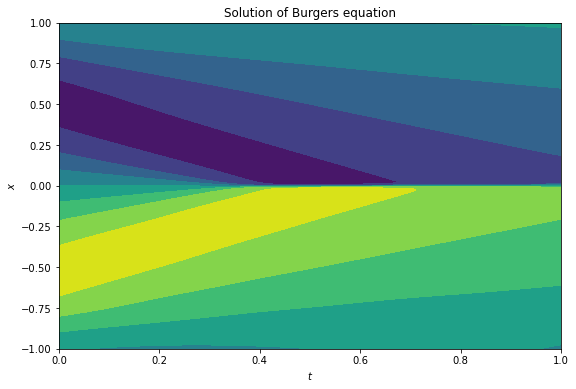

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T
Xgrid = torch.tensor(Xgrid,dtype=torch.float32)


# Determine predictions of u(t, x)

upred = NN_IB(Xgrid) + D_NN(Xgrid) * u_tilda(Xgrid)
#upred = NN_IB(Xgrid)*torch.exp(-15.*D_NN(Xgrid)) + D_NN(Xgrid) * u_tilda(Xgrid)
#upred = NN_IB(Xgrid)
#upred = D_NN(Xgrid)


# Reshape upred
U = upred.detach().numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(111)
#ax.plot_surface(T, X, U, cmap='viridis');
ax.contourf(T,X,U)
#ax.view_init(90,0)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
#ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');
#plt.savefig('Burgers_solution.pdf', bbox_inches='tight', dpi=300);

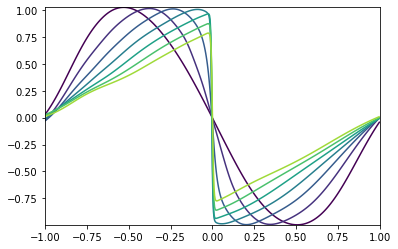

In [31]:
plt.figure()
plt.contour(X,U,T)
#plt.contour(X,U,T,levels=1)
plt.show()

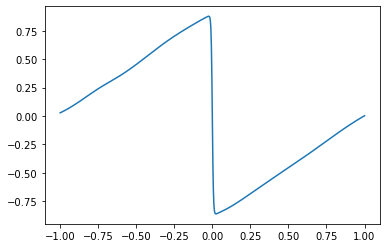

In [32]:
plt.plot(X[:, 450],U[:,450])

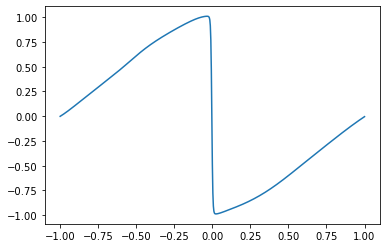

In [33]:
plt.plot(X[:, 300],U[:,300])

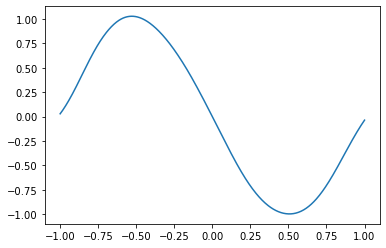

In [34]:
plt.plot(X[:, 0],U[:,0])

In [88]:
""""
PATH1='D_NN_8.pt'
torch.save(D_NN, PATH1)
PATH2='NN_IB_8.pt'
torch.save(NN_IB, PATH2)
PATH3='u_tilda_8.pt'
torch.save(u_tilda, PATH3)
""""